In [1]:
#subset by longitude to look for local effects
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
import plots_spatial as pltspat
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd/")

# Location of masks and grid information for the model
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/topo" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Use dask to load the tabulated data lazily 
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )




In [119]:
###ventilation volumes
#subseting by longitude roughly equivalent to subsetting by x
#try with 10 bins, each approx 36 degrees, or 144 i indices
df_vent['long_bin'] = da.floor(df_vent['binnedx_o']/144)



In [136]:
df  = df_vent[['long_bin','subvol_o','month_o','year_o']]
df_group = df.groupby(['year_o','month_o','long_bin'])
vol = df_group.sum()["subvol_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=1))
vol = vol.sort_values('date')
vol = vol.reset_index()



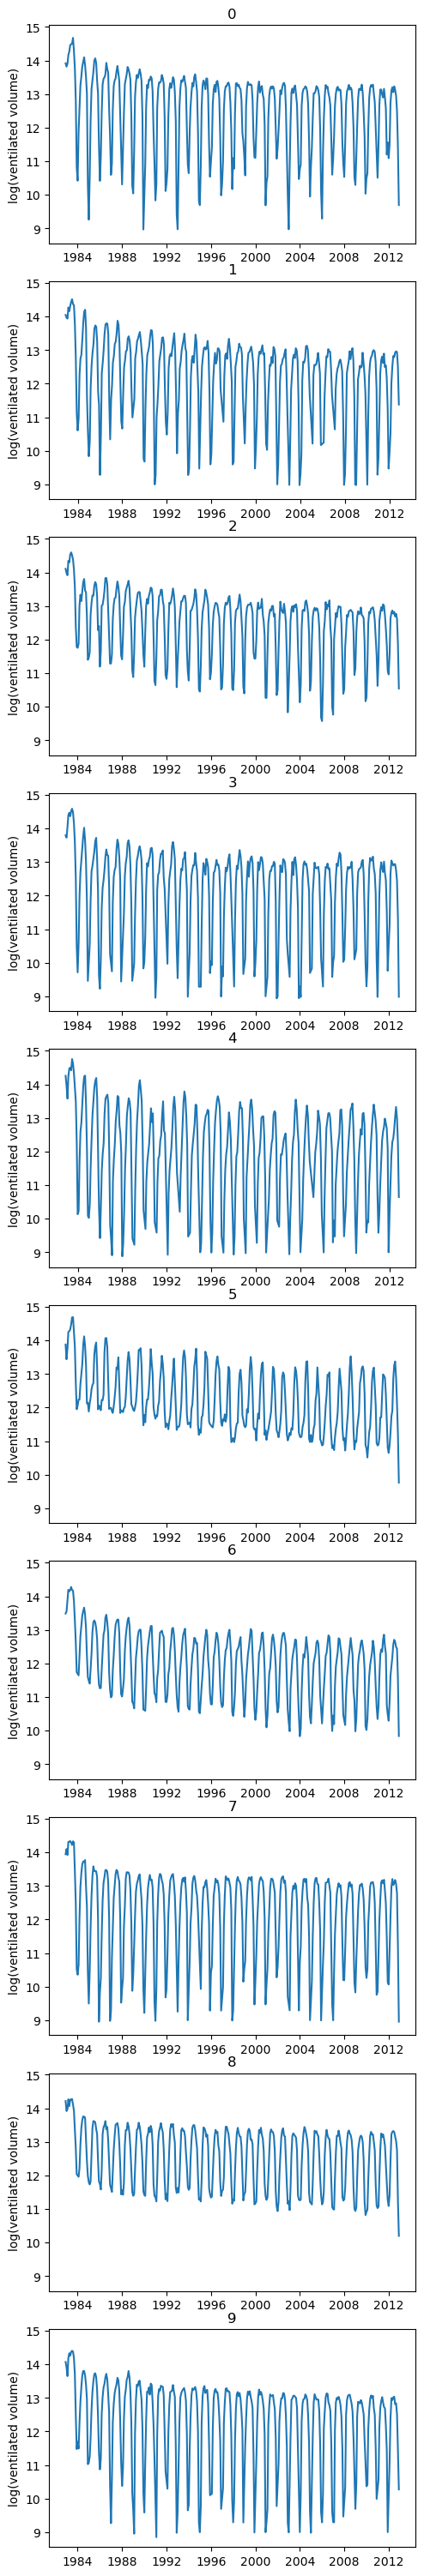

In [137]:
fig,ax = plt.subplots(10,1,figsize=(5,30), sharey=True)
plt.tight_layout()
for bins in range(10):
    vol_filt = vol[vol['long_bin']==bins]
    ax[bins].plot(vol_filt['date'],da.log10(vol_filt['subvol_o']))
    ax[bins].set_ylabel('log(ventilated volume)')
    ax[bins].set_title(bins)

In [122]:
df = df_vent[['binnedx_o','binnedy_o','long_bin']]
long_group=df.groupby(['binnedx_o','binnedy_o'])
grouped_xy=long_group.max("long_bin").compute()
#grouped_xy = grouped_xy.reset_index()

In [123]:
grouped_xy['long_bin']

binnedx_o  binnedy_o
1          111          0.0
           112          0.0
           115          0.0
           116          0.0
           121          0.0
                       ... 
1318       121          9.0
1334       129          9.0
1356       143          9.0
1389       130          9.0
1405       128          9.0
Name: long_bin, Length: 439981, dtype: float64

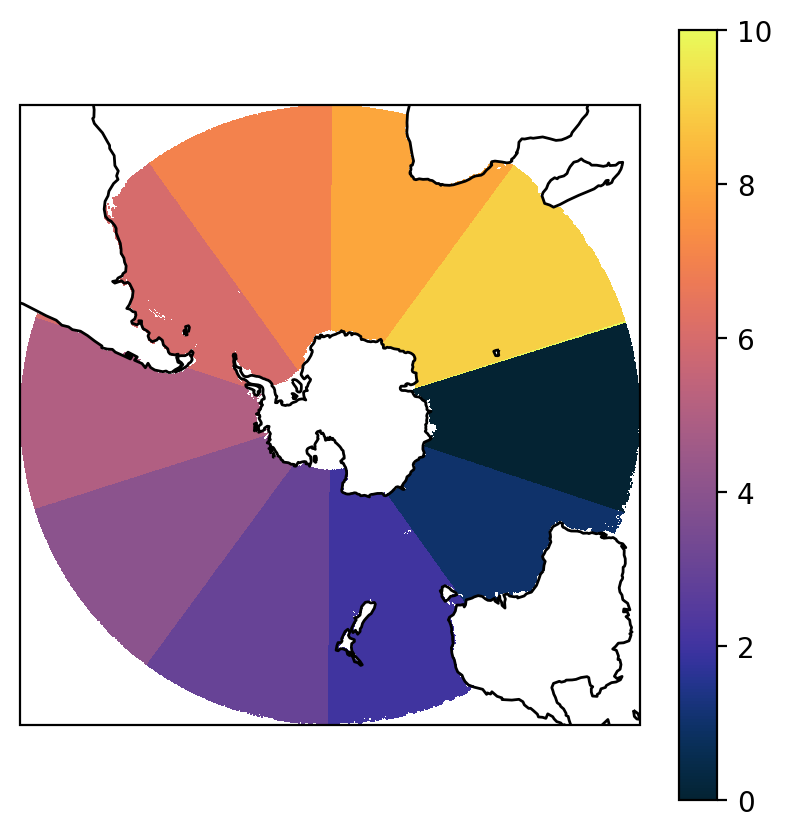

In [124]:




da_vol_xy = grouped_xy.to_xarray()["long_bin"]

# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})

# Reorder axes to agree with ds_subdomain
da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)


# Align the coordinates of the grid file with the subdomain in da_vol_xy
ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )
fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()},figsize=(5,5))
lat = ds_domain_allign.gphit
lon = ds_domain_allign.glamt
xs = ds_domain_allign.e1t
ys =  ds_domain_allign.e2t




cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal )
ax.coastlines()
fig.colorbar(cax)    

In [3]:
######increase resolution in bins4&5 i_ind=577 to 864
#divide into 6 regions, each with  width of x indices 48:

df_interest=df_vent[(df_vent['binnedx_o']>576)&(df_vent['binnedx_o']<1008)]
df_interest=df_interest[(df_interest['binnedy_o']<250)&(df_interest['binnedy_o']>140)]
df_interest['long_bin'] = da.floor(df_interest['binnedx_o']/72-8)




In [73]:
df  = df_interest[['long_bin','subvol_o','month_o','year_o']]
df_group = df.groupby(['year_o','month_o','long_bin'])
vol = df_group.sum()["subvol_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=1))
vol = vol.sort_values('date')
vol = vol.reset_index()


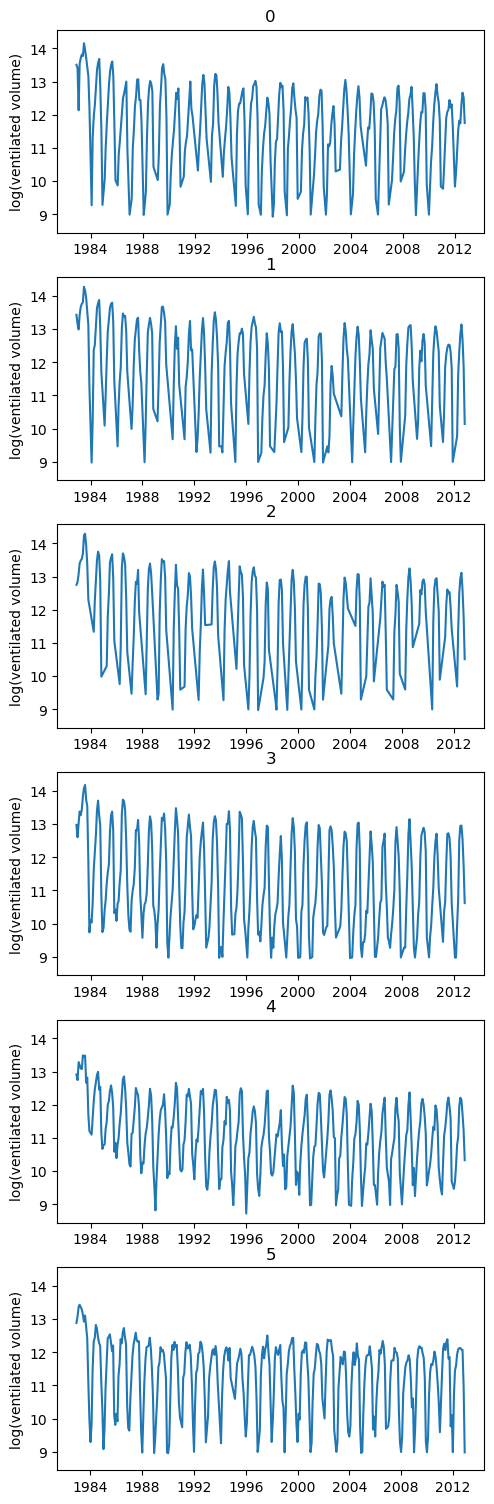

In [78]:
fig,ax = plt.subplots(6,1,figsize=(5,15), sharey=True)
plt.tight_layout()
for bins in range(6):
    vol_filt = vol[vol['long_bin']==bins]
    ax[bins].plot(vol_filt['date'],da.log10(vol_filt['subvol_o']))
    ax[bins].set_ylabel('log(ventilated volume)')
    ax[bins].set_title(bins)

In [79]:
df = df_interest[['binnedx_o','binnedy_o','long_bin']]
long_group=df.groupby(['binnedx_o','binnedy_o'])
grouped_xy=long_group.max("long_bin").compute()


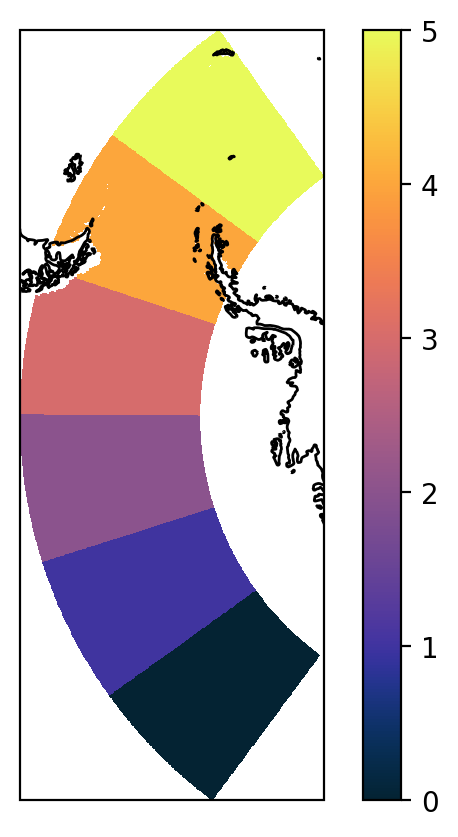

In [80]:

da_vol_xy = grouped_xy.to_xarray()["long_bin"]

# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})

# Reorder axes to agree with ds_subdomain
da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)


# Align the coordinates of the grid file with the subdomain in da_vol_xy
ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )
fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()},figsize=(5,5))
lat = ds_domain_allign.gphit
lon = ds_domain_allign.glamt
xs = ds_domain_allign.e1t
ys =  ds_domain_allign.e2t




cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal )
ax.coastlines()
fig.colorbar(cax)   

In [9]:
##### look at mixed layer depth
df  = df_interest[['long_bin','z_o','month_o','year_o']]
df_group = df.groupby(['year_o','month_o','long_bin'])
vol = df_group.mean()["z_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=1))
vol = vol.sort_values('date')
vol = vol.reset_index()


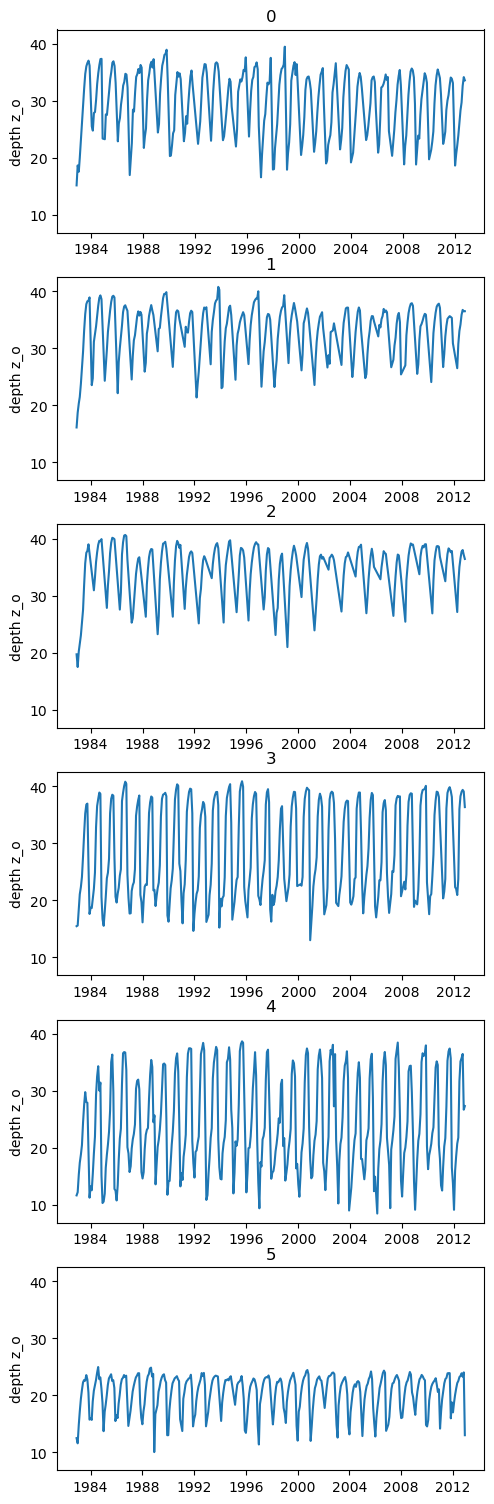

In [12]:
fig,ax = plt.subplots(6,1,figsize=(5,15), sharey=True)
plt.tight_layout()
for bins in range(6):
    vol_filt = vol[vol['long_bin']==bins]
    ax[bins].plot(vol_filt['date'],vol_filt['z_o'])
    ax[bins].set_ylabel('depth z_o')
    ax[bins].set_title(bins)

In [11]:
############ look at initial depth
